# Customer Churn Prediction with XGBoost
_**Using Gradient Boosted Trees to Predict Mobile Customer Departure**_

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
  1. [Relative cost of errors](#Relative-cost-of-errors)
1. [Extensions](#Extensions)

---

## Background



Identifying Credit Card fraudelent transaction is crucial to the banking business to protect their customers from fraud. Identifying fraud transactions is not an easy task and it can consume a lot of auditors time to identify those transactions and it can delay the purchasing of whatever items the card holder wants to purchase.

In this notebook, I will demonstrate how to build an binary classification model to predict whether a specific credit card transaction is genuine of fraud. I will use Sagemaker's implementation of XGBoost algorithm.



## Amazon SageMaker
Amazon SageMaker Amazon SageMaker is a fully managed machine learning service that automates the end-to-end ML process. With Amazon SageMaker, data scientists and developers can quickly and easily build and train machine learning models and directly deploy them into a production-ready hosted environment. It provides an integrated Jupyter authoring notebook instance for easy access to your data sources for exploration and analysis, so you don't have to manage servers. It also provides common machine learning algorithms that are optimized to run efficiently against extremely large data in a distributed environment. With native support for bring-your-own-algorithms and frameworks, Amazon SageMaker offers flexible distributed training options that adjust to your specific workflows. Deploy a model into a secure and scalable environment by launching it with a single click from the Amazon SageMaker console. Training and hosting are billed by minutes of usage, with no minimum fees and no upfront commitments. SageMaker python sdk, is a library that provides the user with the ability to wrap your models in helper classes that can be passed to Amazon SageMaker. The python sdk provides you with the ability to use Amazon Algorithms, train and deploy your own code  using Amazon SagedMaker, and bring your own pre-trained dockerized models. Let us next take a look at the architecture of SageMaker. How does Amazon SageMaker Work: Training Training workloads, for an end-to-end model development includes the following components: • S3 Bucket for the training dataset • Amazon SageMaker notebook instance, a fully managed single tenant EC2 instance. • EC2 cluster for training. (fully managed transparent to developer) • S3 bucket for trained model Hosting • S3 bucket for model • ECS infrastructure to host a dockerized model (fully managed transparent to developer) • EC2 cluster manages by ECS • Model Endpoints, elastically scalable callable inference endpoints. (fully managed transparent to developer)

---

## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [44]:
# Define IAM role
import boto3
import re
import sagemaker
import seaborn as sns

role = sagemaker.get_execution_role()

#Manage interactions with the Amazon SageMaker APIs and any other AWS services needed.
#manipulating entities and resources that Amazon SageMaker uses, such as training jobs, endpoints, and input datasets in S3.
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'DEMO-xgboost-fraud-detection'


INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-625616379791


Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [55]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_columns', 500)

---
## Data


The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

The dataset we use is publicly available at https://www.kaggle.com/mlg-ulb/creditcardfraud

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

In [56]:
credit_df = pd.read_csv('./creditcard.csv')
credit_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.620000,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,1.000000,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660000,0
3,1.000000,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,2.000000,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.990000,0


# Exploratory Data Analysis

### 1- Get The Dataframe Summary

In [57]:
credit_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,94813.859575,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,88.349619,0.001727
std,47488.145955,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,1.088850,1.020713,0.999201,0.995274,0.958596,0.915316,0.876253,0.849337,0.838176,0.814041,0.770925,0.734524,0.725702,0.624460,0.605647,0.521278,0.482227,0.403632,0.330083,250.120109,0.041527
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54201.500000,-0.920373,-0.598550,-0.890365,-0.848640,-0.691597,-0.768296,-0.554076,-0.208630,-0.643098,-0.535426,-0.762494,-0.405571,-0.648539,-0.425574,-0.582884,-0.468037,-0.483748,-0.498850,-0.456299,-0.211721,-0.228395,-0.542350,-0.161846,-0.354586,-0.317145,-0.326984,-0.070840,-0.052960,5.600000,0.000000
50%,84692.000000,0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,0.022358,-0.051429,-0.092917,-0.032757,0.140033,-0.013568,0.050601,0.048072,0.066413,-0.065676,-0.003636,0.003735,-0.062481,-0.029450,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,22.000000,0.000000
75%,139320.500000,1.315642,0.803724,1.027196,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,0.453923,0.739593,0.618238,0.662505,0.493150,0.648821,0.523296,0.399675,0.500807,0.458949,0.133041,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.091045,0.078280,77.165000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


### 2- Checking The Balance of The Data

Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

In [5]:
print('The number of Non-Frauds are: ' + str(credit_df['Class'].value_counts()[0]) + ' which is ', round(credit_df['Class'].value_counts()[0]/len(credit_df) * 100,2), '% of the dataset')
print('The number of Frauds are: ' + str(credit_df['Class'].value_counts()[1]) + ' which is ', round(credit_df['Class'].value_counts()[1]/len(credit_df) * 100,2), '% of the dataset')


The number of Non-Frauds are: 284315 which is  99.83 % of the dataset
The number of Frauds are: 492 which is  0.17 % of the dataset


#### Plot the Class Distribution

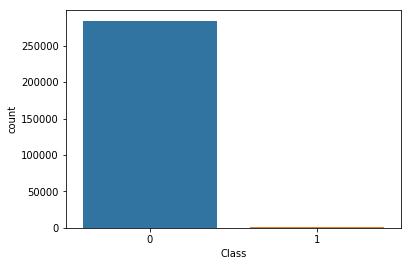

In [35]:
sns.countplot('Class', data=credit_df)

### 3- Checking Missing Data

If there are any missing data in our dataset, we need to deal with them before training. Data Imputation is a critical step in the Feature Engineering phase.

In [27]:
credit_df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### 3- Feature Correlation

A correlation matrix is a way to show the correlation between different variables in a dataset. Each cell in the table shows the correlation between two variables. A correlation matrix is used to summarize data and find what , as an input into a more advanced analysis

**Positive Correlation means:** As feature X increases, feature Y increases and vice versa.

**Negative Correlation means:** As feature X go in one direction (Increase), feature Y goes in the other direction (Decrease)

Let's plot the first correlation matrix for the imbalanced data.

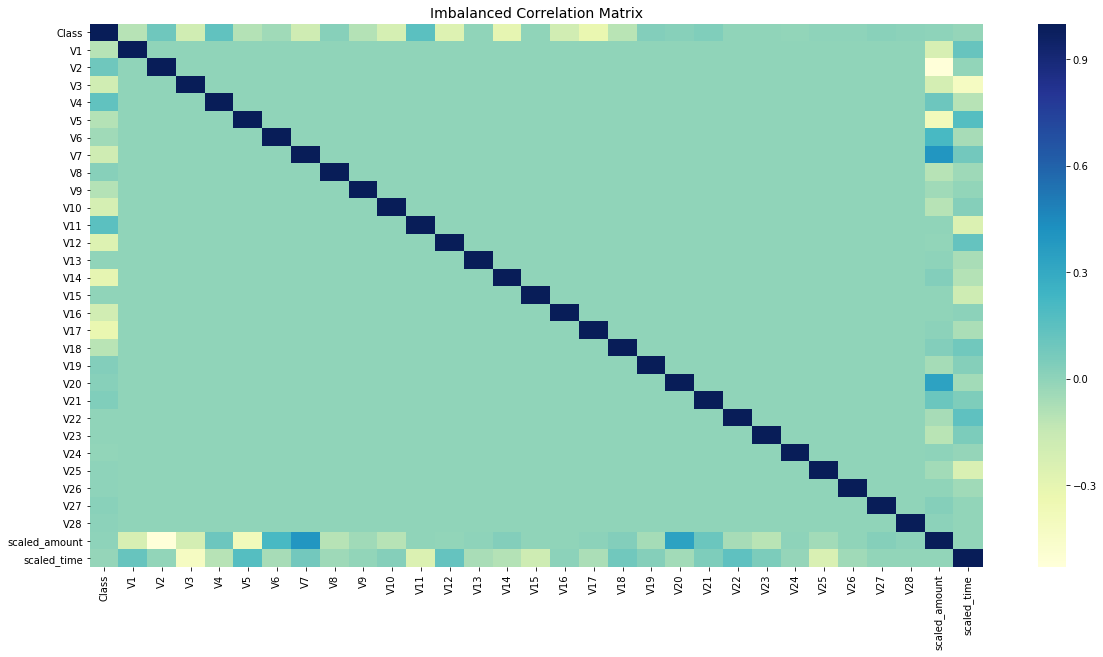

In [36]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))         

# Imbalanced DataFrame Correlation
corr = credit_df.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)

plt.show()

# Feature Engineering

### 1- Fixing The Feature Scaling Problem For (Time and Amount)

In [58]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

credit_df['scaled_amount'] = rob_scaler.fit_transform(credit_df['Amount'].values.reshape(-1,1))
credit_df['scaled_time'] = rob_scaler.fit_transform(credit_df['Time'].values.reshape(-1,1))

credit_df.drop(['Time','Amount'], axis=1, inplace=True)

# Place the class in the begining of the dataframe
Class = credit_df['Class']
credit_df.drop(['Class'], axis=1, inplace=True)
credit_df.insert(0, 'Class', Class)

In [60]:
credit_df.describe()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,0.001727,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.927124,0.118914
std,0.041527,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,1.088850,1.020713,0.999201,0.995274,0.958596,0.915316,0.876253,0.849337,0.838176,0.814041,0.770925,0.734524,0.725702,0.624460,0.605647,0.521278,0.482227,0.403632,0.330083,3.495006,0.557903
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,-0.307413,-0.994983
25%,0.000000,-0.920373,-0.598550,-0.890365,-0.848640,-0.691597,-0.768296,-0.554076,-0.208630,-0.643098,-0.535426,-0.762494,-0.405571,-0.648539,-0.425574,-0.582884,-0.468037,-0.483748,-0.498850,-0.456299,-0.211721,-0.228395,-0.542350,-0.161846,-0.354586,-0.317145,-0.326984,-0.070840,-0.052960,-0.229162,-0.358210
50%,0.000000,0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,0.022358,-0.051429,-0.092917,-0.032757,0.140033,-0.013568,0.050601,0.048072,0.066413,-0.065676,-0.003636,0.003735,-0.062481,-0.029450,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,0.000000,0.000000
75%,0.000000,1.315642,0.803724,1.027196,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,0.453923,0.739593,0.618238,0.662505,0.493150,0.648821,0.523296,0.399675,0.500807,0.458949,0.133041,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.091045,0.078280,0.770838,0.641790
max,1.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,358.683155,1.035022


We can see immediately that:
- `time_after_scaling` appears to be quite evenly distributed and scaled with min and max values are within the range of the other features
- `amount_after_scaling` transaction amount values are also scaled to be within the range of the other features with min of -0.307 and max of 358.68

### 2- Fix the target feature imbalance problem (Resampling)

<img src="./resampling.png">

#### Undersampling The Class Feature

In [68]:
# Shuffle the Dataset.
shuffled_df = credit_df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = shuffled_df.loc[shuffled_df['Class'] == 1]

#Randomly select 492 observations.
non_fraud_df = shuffled_df.loc[shuffled_df['Class'] == 0].sample(n=492)
normalized_df = pd.concat([fraud_df, non_fraud_df])

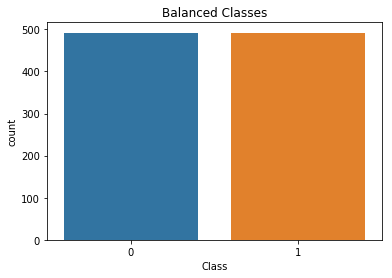

In [69]:
sns.countplot('Class', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

#### Shuffle the normalized dataset before splitting

In [72]:
shuffled_normalized_df = normalized_df.sample(frac=1)
shuffled_normalized_df.head()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
276839,0,1.988976,0.152075,-1.721576,0.559875,0.176754,-1.502428,0.367936,-0.444919,0.482977,-0.508305,-0.224355,0.431369,0.684093,-0.856023,0.826606,0.172494,0.361865,0.420144,-0.451801,-0.091169,0.225404,0.780418,-0.058630,0.003099,0.262236,-0.110064,-0.004550,-0.023412,0.234053,0.970794
70141,1,-1.649279,1.263974,-1.050826,2.237991,-2.527889,-0.889940,-2.355254,0.854659,-1.281243,-2.705011,1.174475,-4.381920,-1.226666,-2.953824,1.994161,-3.304254,-5.585794,-1.643704,2.118633,0.087406,0.679176,0.731907,0.333045,0.392505,-0.274197,0.802349,0.390809,0.112146,1.263886,-0.363785
42741,1,-9.001351,6.613284,-12.423635,7.519929,-10.266255,-2.113208,-9.984287,5.541941,-7.383705,-13.215172,6.895181,-13.279700,0.755264,-13.417012,-0.210774,-10.922655,-21.906493,-8.829820,1.852467,-0.645394,1.775891,-1.224758,0.082594,0.452089,0.463827,-0.296928,0.526506,-0.450890,6.107315,-0.510638
190774,0,-2.682184,-1.148645,1.258870,-2.531184,1.228326,1.691466,0.246707,-0.045485,-0.040970,1.026738,1.166573,-0.389682,-0.593873,-1.121794,-0.541385,0.387883,0.328289,-2.632607,-0.184343,-0.569102,-0.426963,-0.276193,0.409113,-0.777018,0.354082,-0.553396,-1.074592,0.360989,0.111786,0.520295
30473,1,-4.194074,4.382897,-5.118363,4.455230,-4.812621,-1.224645,-7.281328,3.332250,-3.679659,-7.524368,2.954344,-7.099825,1.520369,-7.687803,-0.225002,-8.520850,-13.277300,-5.253705,3.623332,0.579098,1.550473,0.614573,0.028521,0.013704,-0.149512,-0.131687,0.473934,0.473757,-0.105359,-0.572728


## Split the train/test data

In [73]:
train_data, validation_data, test_data = np.split(shuffled_normalized_df, [int(0.7 * len(shuffled_normalized_df)), int(0.9 * len(shuffled_normalized_df))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

Now we'll upload these files to S3.

In [74]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---
## Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.

In [75]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')
container

'811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:1'

Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3.

In [76]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

Binary classification error rate. It is calculated as #(wrong cases)/#(all cases)


More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [78]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=400)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

INFO:sagemaker:Creating training-job with name: xgboost-2019-02-11-09-26-24-447


2019-02-11 09:26:24 Starting - Starting the training job...
2019-02-11 09:26:26 Starting - Launching requested ML instances......
2019-02-11 09:27:33 Starting - Preparing the instances for training......
2019-02-11 09:28:37 Downloading - Downloading input data..
Arguments: train
[2019-02-11:09:29:03:INFO] Running standalone xgboost training.
[2019-02-11:09:29:03:INFO] File size need to be processed in the node: 0.48mb. Available memory size in the node: 8423.25mb
[2019-02-11:09:29:03:INFO] Determined delimiter of CSV input is ','
[09:29:03] S3DistributionType set as FullyReplicated
[09:29:03] 688x30 matrix with 20640 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-02-11:09:29:03:INFO] Determined delimiter of CSV input is ','
[09:29:03] S3DistributionType set as FullyReplicated
[09:29:03] 197x30 matrix with 5910 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[09:29:03] src/tree/updater_prune.cc:74: tree pr


2019-02-11 09:29:15 Training - Training image download completed. Training in progress.
2019-02-11 09:29:15 Uploading - Uploading generated training model
2019-02-11 09:29:15 Completed - Training job completed
Billable seconds: 38


---
## Host

Now that we've trained the algorithm, let's create a model and deploy it to a hosted endpoint.

In [79]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2019-02-11-09-30-51-324
INFO:sagemaker:Creating endpoint with name xgboost-2019-02-11-09-26-24-447


----------------------------------------------------------------------------!

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [82]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [83]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.as_matrix()[:, 1:])

There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values.  In this case, we're simply predicting whether the credit card transaction is Fraud (`1`) or not (`0`), which produces a simple confusion matrix.

#### Print Confusion Matrix
<img src="./Confusion_matrix.png">


In [84]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,61,2
1,4,32


_Note, due to randomized elements of the algorithm, you results may differ slightly._

Of the 48 churners, we've correctly predicted 39 of them (true positives). And, we incorrectly predicted 4 customers would churn who then ended up not doing so (false positives).  There are also 9 customers who ended up churning, that we predicted would not (false negatives).

An important point here is that because of the `np.round()` function above we are using a simple threshold (or cutoff) of 0.5.  Our predictions from `xgboost` come out as continuous values between 0 and 1 and we force them into the binary classes that we began with.  However, because a customer that churns is expected to cost the company more than proactively trying to retain a customer who we think might churn, we should consider adjusting this cutoff.  That will almost certainly increase the number of false positives, but it can also be expected to increase the number of true positives and reduce the number of false negatives.

To get a rough intuition here, let's look at the continuous values of our predictions.

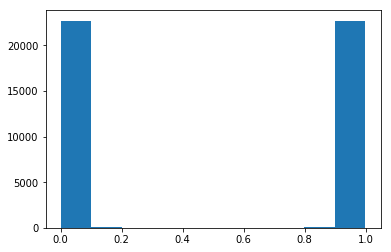

In [41]:
plt.hist(predictions)
plt.show()

The continuous valued predictions coming from our model tend to skew toward 0 or 1, but there is sufficient mass between 0.1 and 0.9 that adjusting the cutoff should indeed shift a number of customers' predictions.  For example...

In [85]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.3, 1, 0))

col_0,0,1
Class,,
0,59,4
1,3,33


We can see that changing the cutoff from 0.5 to 0.3 results in 1 more true positives, 3 more false positives, and 1 fewer false negatives.  The numbers are small overall here, but that's 6-10% of customers overall that are shifting because of a change to the cutoff.  Was this the right decision?  We may end up retaining 3 extra customers, but we also unnecessarily incentivized 5 more customers who would have stayed.  Determining optimal cutoffs is a key step in properly applying machine learning in a real-world setting.  Let's discuss this more broadly and then apply a specific, hypothetical solution for our current problem.

### Relative cost of errors

Any practical binary classification problem is likely to produce a similarly sensitive cutoff. That by itself isn’t a problem. After all, if the scores for two classes are really easy to separate, the problem probably isn’t very hard to begin with and might even be solvable with simple rules instead of ML.

More important, if I put an ML model into production, there are costs associated with the model erroneously assigning false positives and false negatives. I also need to look at similar costs associated with correct predictions of true positives and true negatives.  Because the choice of the cutoff affects all four of these statistics, I need to consider the relative costs to the business for each of these four outcomes for each prediction.

#### Assigning costs

What are the costs for our problem of mobile operator churn? The costs, of course, depend on the specific actions that the business takes. Let's make some assumptions here.

First, assign the true negatives the cost of \$0. Our model essentially correctly identified a happy customer in this case, and we don’t need to do anything.

False negatives are the most problematic, because they incorrectly predict that a churning customer will stay. We lose the customer and will have to pay all the costs of acquiring a replacement customer, including foregone revenue, advertising costs, administrative costs, point of sale costs, and likely a phone hardware subsidy. A quick search on the Internet reveals that such costs typically run in the hundreds of dollars so, for the purposes of this example, let's assume \$500. This is the cost of false negatives.

Finally, for customers that our model identifies as churning, let's assume a retention incentive in the amount of \\$100. If my provider offered me such a concession, I’d certainly think twice before leaving. This is the cost of both true positive and false positive outcomes. In the case of false positives (the customer is happy, but the model mistakenly predicted churn), we will “waste” the \\$100 concession. We probably could have spent that \\$100 more effectively, but it's possible we increased the loyalty of an already loyal customer, so that’s not so bad.

#### Finding the optimal cutoff

It’s clear that false negatives are substantially more costly than false positives. Instead of optimizing for error based on the number of customers, we should be minimizing a cost function that looks like this:

```txt
$500 * FN(C) + $0 * TN(C) + $100 * FP(C) + $100 * TP(C)
```

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP.  We need to find the cutoff, C, where the result of the expression is smallest.

A straightforward way to do this, is to simply run a simulation over a large number of possible cutoffs.  We test 100 possible values in the for loop below.

In [ ]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[0, 100], [500, 100]]) * 
                               pd.crosstab(index=test_data.iloc[:, 0], 
                                           columns=np.where(predictions > c, 1, 0)))))

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))

The above chart shows how picking a threshold too low results in costs skyrocketing as all customers are given a retention incentive.  Meanwhile, setting the threshold too high results in too many lost customers, which ultimately grows to be nearly as costly.  The overall cost can be minimized at \\$ 8400 by setting the cutoff to 0.46, which is substantially better than the
\\$ 20k+ I would expect to lose by not taking any action.

---
## Extensions

This notebook showcased how to build a model that predicts whether a customer is likely to churn, and then how to optimally set a threshold that accounts for the cost of true positives, false positives, and false negatives.  There are several means of extending it including:
- Some customers who receive retention incentives will still churn.  Including a probability of churning despite receiving an incentive in our cost function would provide a better ROI on our retention programs.
- Customers who switch to a lower-priced plan or who deactivate a paid feature represent different kinds of churn that could be modeled separately.
- Modeling the evolution of customer behavior. If usage is dropping and the number of calls placed to Customer Service is increasing, you are more likely to experience churn then if the trend is the opposite. A customer profile should incorporate behavior trends.
- Actual training data and monetary cost assignments could be more complex.
- Multiple models for each type of churn could be needed.

Regardless of additional complexity, similar principles described in this notebook are likely apply.

### Optimizing model for prediction using Neo API
Neo API allows to optimize our model for a specific hardware type. When calling `compile_model()` function, we specify the target instance family (C5) as well as the S3 bucket to which the compiled model would be stored.

**Important. If the following command result in a permission error, scroll up and locate the value of execution role returned by `get_execution_role()`. The role must have access to the S3 bucket specified in ``output_path``.**

In [ ]:
output_path = '/'.join(xgb.output_path.split('/')[:-1])
compiled_model = xgb.compile_model(target_instance_family='ml_c5', 
                                   input_shape={'data':[1, 69]},
                                   role=role,
                                   framework='xgboost',
                                   framework_version='0.7',
                                   output_path=output_path)

### Creating an inference Endpoint

We can deploy this compiled model, note that we need to use the same instance that the target we used for compilation. This creates a SageMaker endpoint that we can use to perform inference. 

The arguments to the ``deploy`` function allow us to set the number and type of instances that will be used for the Endpoint. Make sure to choose an instance for which you have compiled your model, so in our case  `ml_c5`. Neo API uses a special runtime (DLR runtime), in which our optimzed model will run.

In [ ]:
# known issue: need to manually specify endpoint name
compiled_model.name = 'deployed-xgboost-customer-churn'
# There is a known issue where SageMaker SDK locates the incorrect docker image URI for XGBoost
# For now, we manually set Image URI
compiled_model.image = get_image_uri(sess.boto_region_name, 'xgboost-neo', repo_version='latest')
compiled_predictor = compiled_model.deploy(initial_instance_count = 1, instance_type = 'ml.c5.4xlarge')

### Making an inference request
The compiled model accepts CSV content type:

In [ ]:
compiled_predictor.content_type = 'text/csv'
compiled_predictor.serializer = csv_serializer
compiled_predictor.deserializer = None

In [ ]:
def optimized_predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, compiled_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

# Batch prediction is not supported yet; need to send one data point at a time
dtest = test_data.as_matrix()
predictions = []
for i in range(dtest.shape[0]):
    predictions.append(optimized_predict(dtest[i:i+1, 1:]))
predictions = np.array(predictions).squeeze()
predictions

### (Optional) Clean-up

If you're ready to be done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)
sagemaker.Session().delete_endpoint(compiled_predictor.endpoint)

In [63]:
data = np.random.rand(7, 10)
type(data)

numpy.ndarray

In [69]:
import pickle
import xgboost as xgb
test = "0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62".split(',')
data = np.asarray(test).reshape((1,-1))
test_matrix = xgb.DMatrix(data)
filename = "./xgboost-model"
xgb_loaded = pickle.load(open(filename, 'rb'))

In [70]:
predictions = xgb_loaded.predict(test_matrix)

In [72]:
predictions[0]

0.9338594

In [80]:
from xgboost import plot_tree, Booster
import xgboost as xgb
import matplotlib.pyplot as plt
import pickle as pkl
from xgboost import plot_tree, plot_importance

from matplotlib.pylab import rcParams
# plot single tree
rcParams['figure.figsize'] = 50,50
 
model = pkl.load(open(filename,'rb')) 
#xgb.Booster(model_file="./xgboost-model")
plot_tree(xgb_loaded, num_trees=10)
plt.show()


NameError: name 'filename' is not defined

In [ ]:
!pip show xgboost

## Oversampling

In [8]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')



print('No Frauds', round(credit_df['Class'].value_counts()[0]/len(credit_df) * 100,2), '% of the dataset')
print('Frauds', round(credit_df['Class'].value_counts()[1]/len(credit_df) * 100,2), '% of the dataset')

X = credit_df.drop('Class', axis=1)
y = credit_df['Class']

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()


log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [265518 180305  42664 ...  29062  13766  17677] Test: [263020  11378 147283 ... 274532 269819  64170]
Train: [ 72227 114282  16818 ... 264471 191914 284017] Test: [202638  32978 128121 ... 244024 127667  48318]
Train: [ 20895 114622 167683 ... 244502 178972 218506] Test: [284352  82483  90981 ... 171224 168807 271602]
Train: [122248 181660 194400 ... 104631 277586  29432] Test: [225673  63348  68025 ... 279451  77554  76043]
Train: [241684 223467 136928 ...  86495 160550  49633] Test: [157557 204860  83760 ... 251478 178967 216850]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827075 0.00172925]
[0.99827955 0.00172045]
Length of X (train): 227845 | Length of y (train): 227845
Length of X (test): 56962 | Length of y (test): 56962
-------------------------------------------------------------------------------------------------------------

In [9]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [17]:
import numpy
unique, counts = numpy.unique(ysm_train, return_counts=True)

In [18]:
counts

array([227451, 227451])

In [19]:
unique

array([0, 1])

(454902, 30)

In [21]:
x_train = pd.DataFrame(Xsm_train)
x_train.insert(0, 'Class', ysm_train)

In [24]:
train_data, validation_data, test_data = np.split(x_train.sample(frac=1), [int(0.7 * len(x_train.sample(frac=1))), int(0.9 * len(x_train.sample(frac=1)))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')